## Preprocessing

In [1]:
##Activating the virtual environment
import os
os.getcwd()
path='/work/tildes_folder/Notebooks_fMRI' # Change this to your own notebook_fmri path
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


In [1]:
##Importing packages
from os.path import join

import matplotlib.pyplot as plt
import mne
import pandas as pd
import numpy as np

import glob

Matplotlib is building the font cache; this may take a moment.


In [2]:
##Loading the data

#!CONFUSION: Do we just load in all the data together?

data_path = "/work/MEG_data"
ID = "0144"
date_stamp = "20240924_000000"
sess = "A"

log_path = join(data_path, 'logfiles')

meg_path = join(data_path, ID, date_stamp, "MEG/001.sessA/files")
#bem_path = "/work/MEG_data/freesurfer/" + "0108/bem"    #How to get bem for each subject through freesurfer?
subjects_dir = "/work/freesurfer/"
raw_name = "sess" + sess + ".fif"


In [3]:
##Reading the data
fname = join(meg_path, raw_name)
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file /work/MEG_data/0144/20240924_000000/MEG/001.sessA/files/sessA.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 365000 ... 1174999 =    365.000 ...  1174.999 secs
Ready.
Reading 0 ... 809999  =      0.000 ...   809.999 secs...


/tmp/ipykernel_374/1531496218.py:3: RuntimeWarning: This filename (/work/MEG_data/0144/20240924_000000/MEG/001.sessA/files/sessA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


In [4]:
##Check what we got
raw.info

<Info | 23 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, EOG002, ECG003, IASX+, IASX-, IASY+, IASY-, IASZ+, ...
 chs: 2 EOG, 1 ECG, 11 Internal Active Shielding data (Triux systems), 102 Magnetometers, 204 Gradiometers, 1 misc, 1 Stimulus, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 description: TRIUX system at Aarhus-3103
 dev_head_t: MEG device -> head transform
 dig: 167 items (3 Cardinal, 4 HPI, 160 Extra)
 events: 1 item (list)
 experimenter: Andreas Hojlund (hojlund)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2024-09-24 11:31:52 UTC
 meas_id: 4 items (dict)
 nchan: 323
 proj_id: 1 item (ndarray)
 proj_name: cogsci_teaching
 projs: planar-Raw-0.000-120.000-PCA-01: off, planar- ...
 sfreq: 1000.0 Hz
 subject_info: 6 items (dict)
>

Using matplotlib as 2D backend.


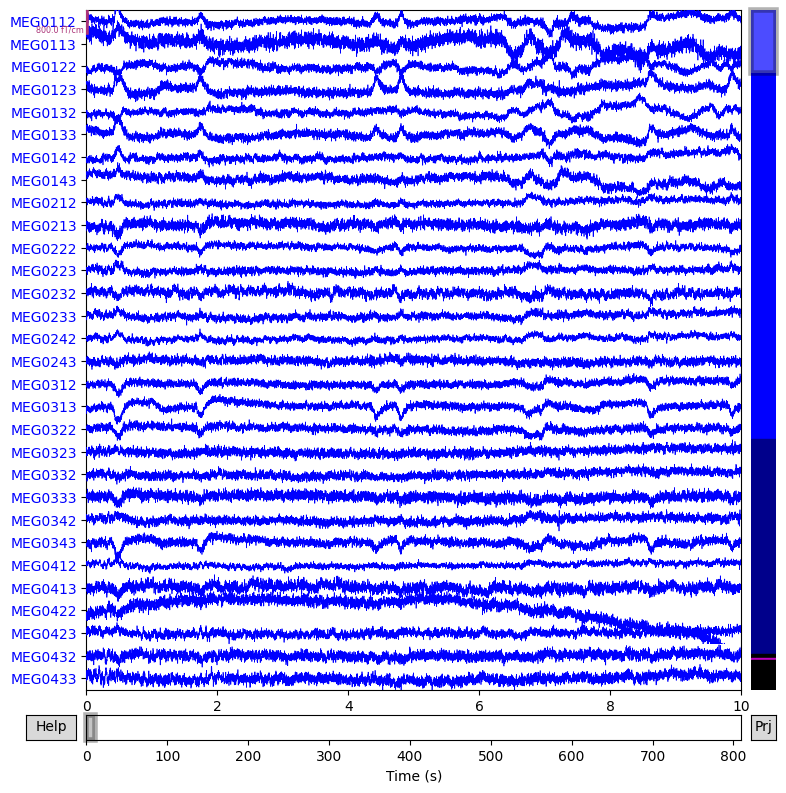

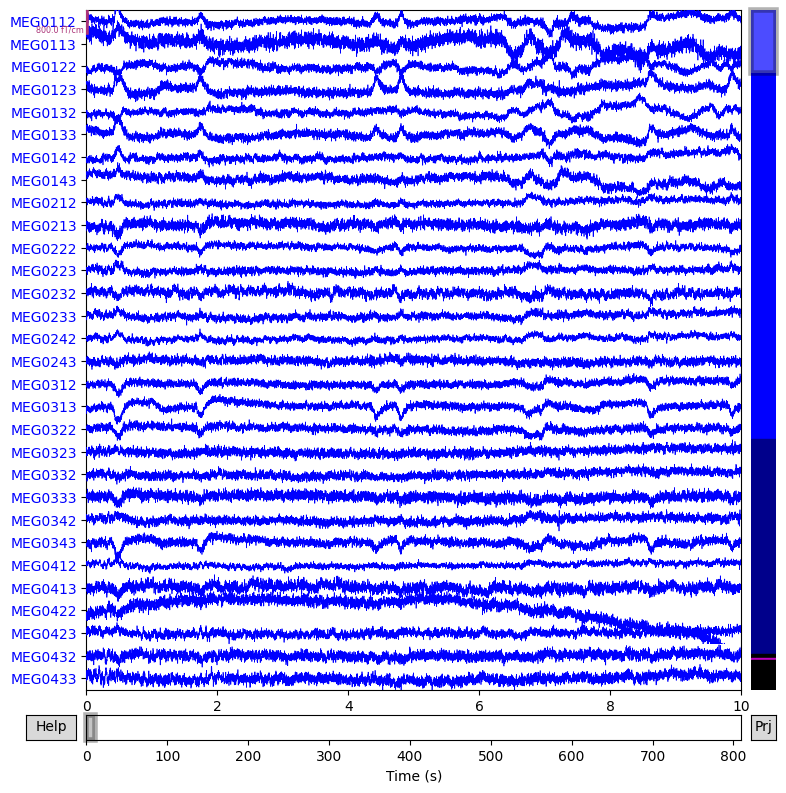

In [5]:
#Inspect the data
raw.plot(n_channels=30)

In [6]:
##Apply low pass filter
# Apply a low-pass filter at 40 Hz (i.e., everything below 40 Hz passes through the filter)
raw.filter(l_freq=None, h_freq=40, n_jobs=4)  # alters raw in-place

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 204 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 306 out of 306 | elapsed:    9.1s finished


<Raw | sessA.fif, 323 x 810000 (810.0 s), ~1.95 GB, data loaded>

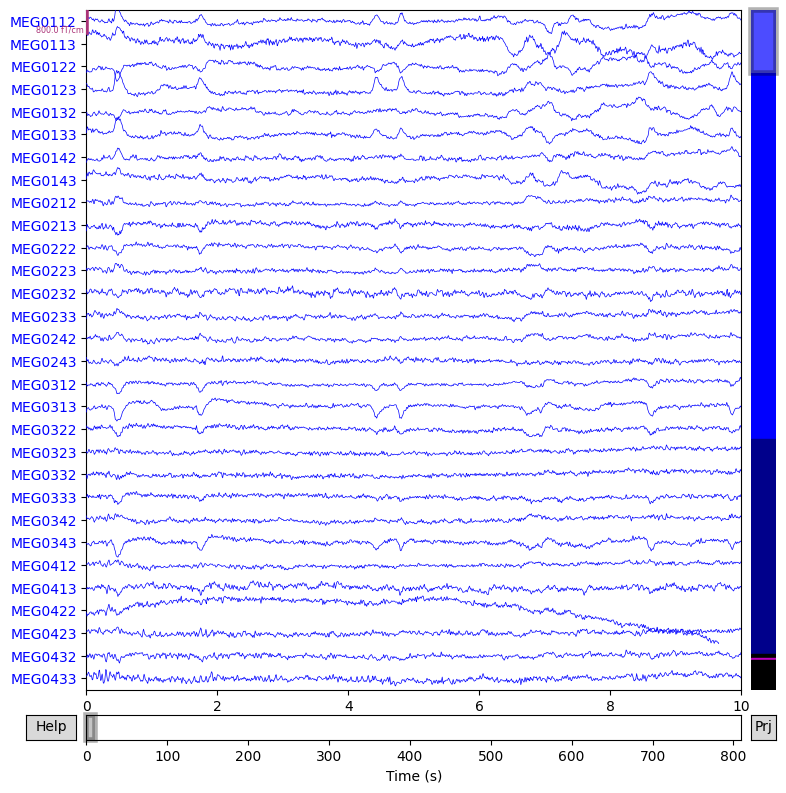

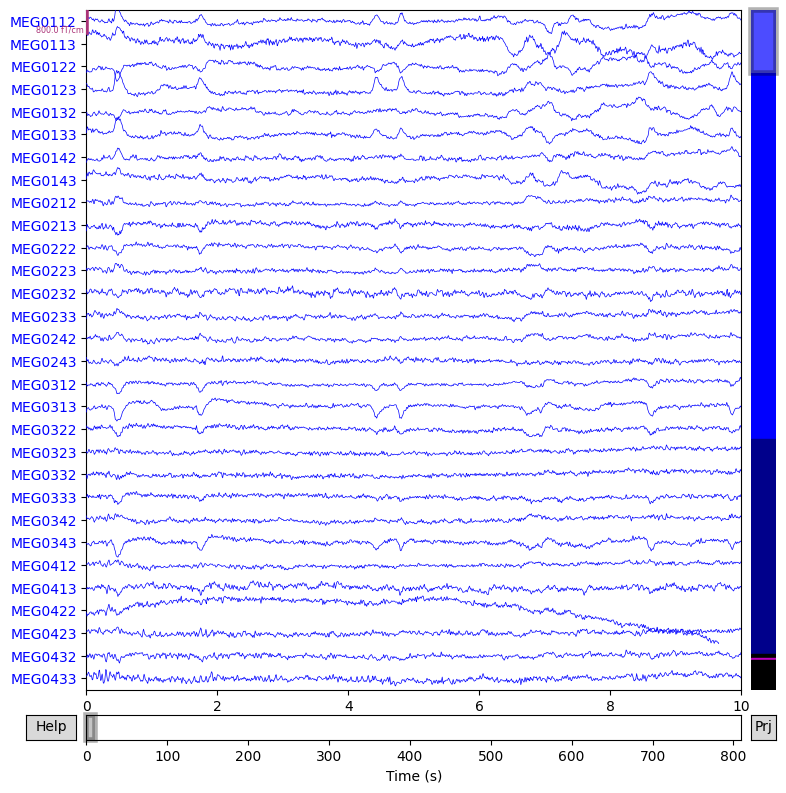

In [7]:
##Inspecting the data again
raw.plot(n_channels=30)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 115.4s.
Creating RawArray with float64 data, n_channels=23, n_times=810000
    Range : 365000 ... 1174999 =    365.000 ...  1174.999 secs
Ready.


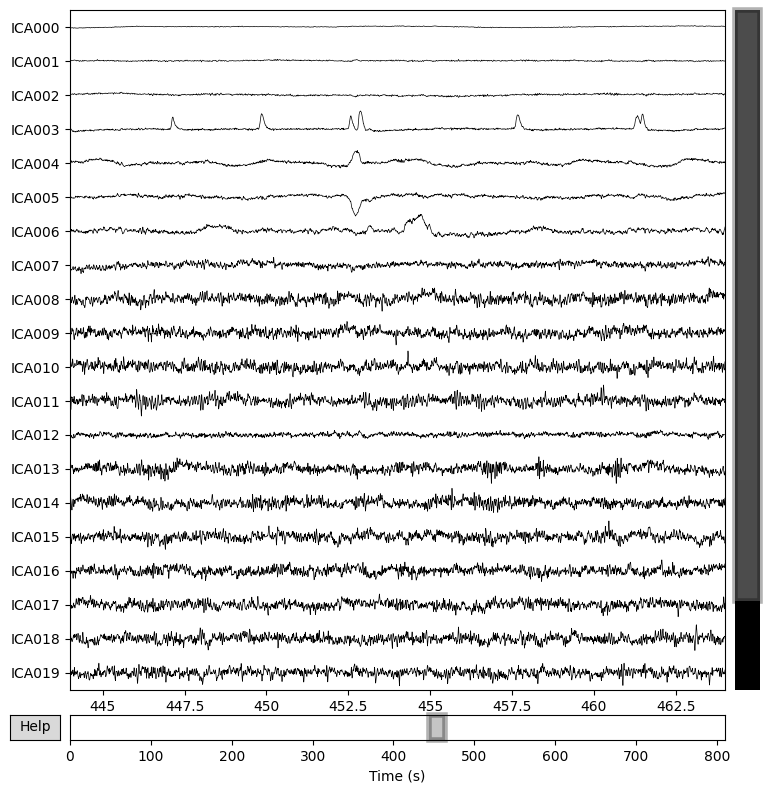

In [8]:
##Independent component analysis for preprocessing

raw.load_data()

orig_raw = raw.copy()
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.plot_sources(raw, start=444); #plotting time courses
ica.plot_components();

Creating RawArray with float64 data, n_channels=23, n_times=810000
    Range : 365000 ... 1174999 =    365.000 ...  1174.999 secs
Ready.


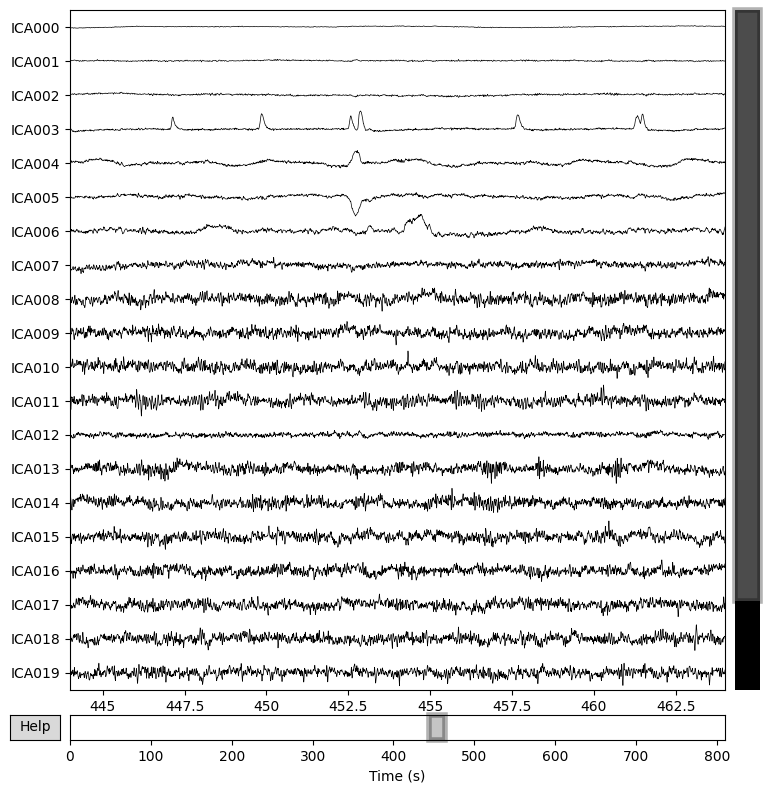

In [9]:
ica.plot_sources(raw, start=444); #plotting time courses

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
405 matching events found
No baseline correction applied
0 projection items activated


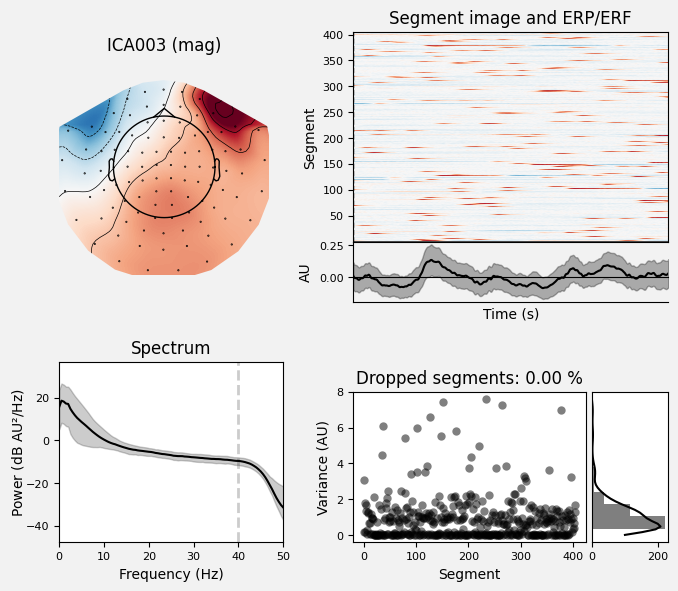

In [10]:
##Decide on components to exclude
ica.exclude=[3]
ica.plot_properties(raw, picks=ica.exclude);

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 306 PCA components


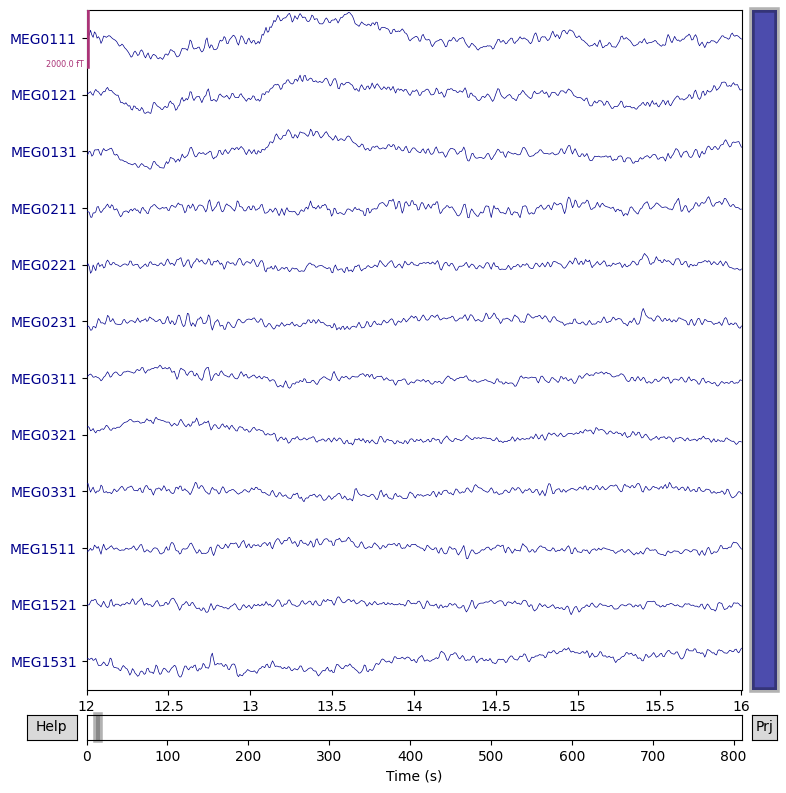

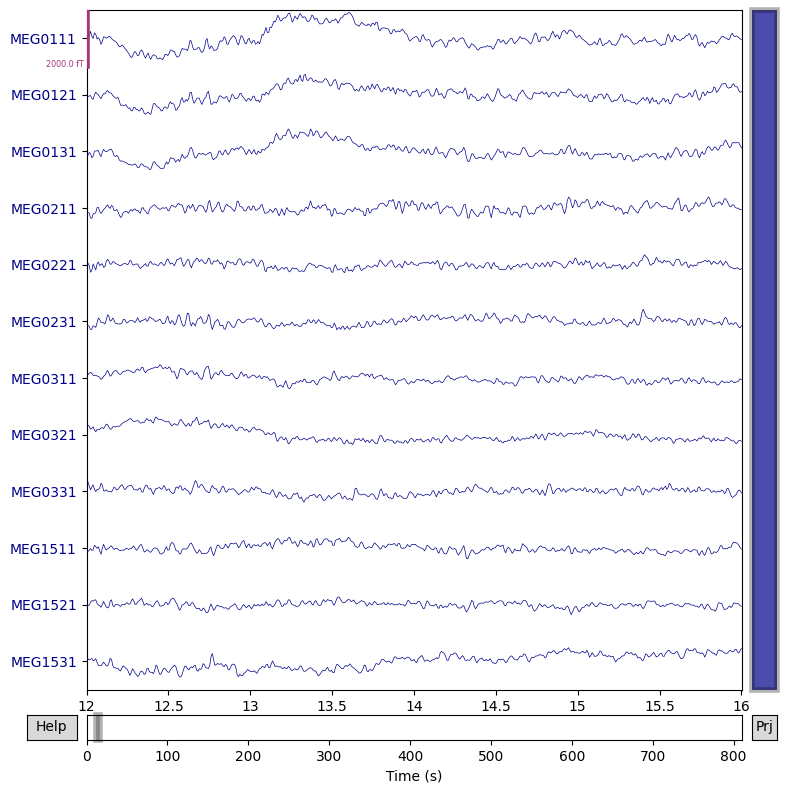

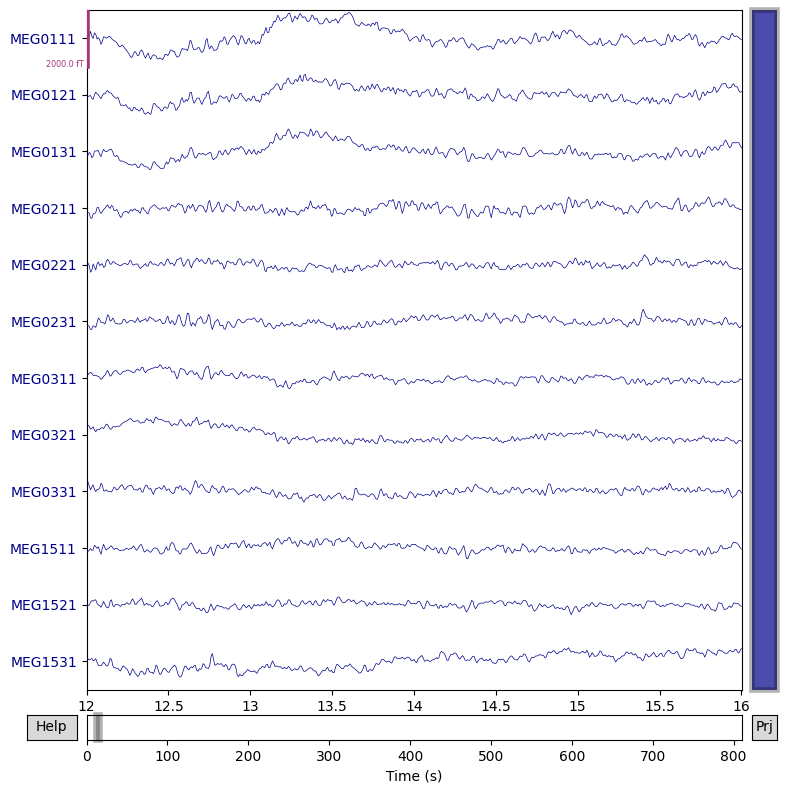

In [11]:
raw.load_data()
ica.apply(raw)

#show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG0111', 'MEG0121', 'MEG0131', 'MEG0211', 'MEG0221', 'MEG0231',
       'MEG0311', 'MEG0321', 'MEG0331', 'MEG1511', 'MEG1521', 'MEG1531']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)


## Epoching

In [12]:
# %% FIND EVENTS

events = mne.find_events(raw, min_duration=0.002, consecutive=True)  ## returns a numpy array

# due to the online filtering of the MEG data, the square waves that constitute the trigger values 
# in the STI101-channel are sometimes not read very well during this process - and therefore we'll 
# only focus on those triggers that correspond to trigger values that we know are relevant
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

# unfortunately, the STI101-channel is really acting up in this dataset, and therefore multiple of the 
# relevant triggers are sometimes read as repeated values within a few milliseconds... gotta fix that too
# We identify for which rows the difference between two consecutive trigger values is 0 (i.e. they're identical 
# - cuz that shouldn't ever happen (check the event_id to (maybe) make sense of this)
repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

1974 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15  16  17  19 110 120 126 130 134 140
 156 210 211 220 221 223 230 231 238 239 240 241 243 246 247 252 254 255]


In [13]:
print(len(events))
print(len(cropped_events))
mne.viz.plot_events(cropped_events, sfreq=raw.info["sfreq"]);  ## #%% SEGMENT DATA INTO EPOCHS

1974
469


/tmp/ipykernel_374/2957343941.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(cropped_events, sfreq=raw.info["sfreq"]);  ## #%% SEGMENT DATA INTO EPOCHS


In [14]:
# Do we have 160 deck-screens, deck-selection and win-/loss-screens?
print(len(cropped_events[cropped_events[:,2]<10,2]))
print(len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]))
print(len(cropped_events[(cropped_events[:,2]>200) & (cropped_events[:,2]<250), 2]))

160
154
155


In [15]:
# Not quite... we might also wanna check whether the trigger values actually match the logfile-values 
# (given all the fuss about these trigger values)
# Let's bring in the logfiles then...

# loading in the logfiles
log_path = "/work/MEG_data/logfiles"
log_files = glob.glob(join(log_path, str(int(ID)) + sess + '*'))

df_load = []
for lf in np.sort(log_files):
    print(lf)
    df_load.append(pd.read_csv(join(log_path, lf)))
                        
df = pd.concat(df_load)

/work/MEG_data/logfiles/144A_sess_1 (2024-09-24 13-38-17).csv
/work/MEG_data/logfiles/144A_sess_2 (2024-09-24 13-41-30).csv
/work/MEG_data/logfiles/144A_sess_3 (2024-09-24 13-44-51).csv
/work/MEG_data/logfiles/144A_sess_4 (2024-09-24 13-48-01).csv


In [16]:
# cleaning the concatenated logfiles a bit

df_cropped = df.drop(['ID', 'dur_measured_decks', 'offset_decks', 'exp_type', 'offset_win'], axis=1) # throwing out columns with all NaN
df_cropped['deck_marked'] = df_cropped['init_mark'] + 1 # adjusting the indexing of "init_mark" to reflect actual deck-number rather than python index


In [17]:
# quick glance at the deck-screen-labels
df_cropped[['init_mark', 'deck_marked', 'deck_select', 'n_moves']]

init_mark  deck_marked  deck_select  n_moves
0           0            1            3        2
1           0            1            4        3
2           3            4            2        2
3           1            2            3        1
4           2            3            1        2
..        ...          ...          ...      ...
35          2            3            4        1
36          1            2            4        2
37          0            1            4        3
38          3            4            2        2
39          2            3            3        0

[160 rows x 4 columns]

In [18]:
# fixing the few deck-screen labels that were messed up due to the trigger values from button presses happening before the screen appearing
print(df_cropped[['deck_marked']].T.to_numpy()[0])
print(cropped_events[cropped_events[:,2]<10,2])

[1 1 4 2 3 4 1 2 1 2 2 4 1 1 4 2 1 4 4 2 3 2 3 3 2 3 1 4 4 2 3 1 1 1 2 3 2
 3 1 4 1 3 2 2 3 3 4 3 4 1 2 2 2 1 4 4 4 3 3 3 4 2 3 4 1 4 1 4 3 3 4 2 3 4
 3 4 2 2 4 3 2 4 2 1 4 3 3 3 3 2 2 1 1 2 4 4 4 3 1 3 4 2 1 1 3 1 3 1 1 4 1
 4 3 4 3 3 1 4 1 2 1 2 3 2 4 3 2 4 4 1 3 1 4 3 1 4 2 2 1 2 2 2 1 3 4 4 4 3
 4 1 4 1 1 4 1 3 2 1 4 3]
[1 1 4 2 3 4 1 2 1 2 2 4 1 1 4 2 1 4 4 2 3 2 3 3 2 3 1 4 4 2 3 1 1 1 2 3 2
 3 1 4 1 3 2 2 3 3 4 3 4 1 2 2 2 1 4 4 4 3 3 3 4 2 3 4 1 4 1 4 3 3 4 2 3 4
 3 4 2 2 4 3 2 4 2 1 4 3 3 3 3 2 2 1 1 2 4 4 4 3 1 3 4 2 1 1 3 1 3 1 1 4 1
 4 3 4 3 3 1 4 1 2 1 2 3 2 4 3 2 4 4 1 3 1 4 3 1 4 2 2 1 2 2 2 1 3 4 4 4 3
 4 1 4 1 1 4 1 3 2 1 4 3]


In [19]:
#This is the structure of interesting triggers / events
event_id = {'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            'Visual/Deck/Two': 2, # Deck 2 marked
            'Visual/Deck/Three': 3, # Deck 3 marked
            'Visual/Deck/Four': 4, # Deck 4 marked
            'Visual/Win/One': 210, # Win screen, deck 1
            'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            'Visual/Win/Four': 240, # Win screen, deck 4
            'Visual/Loss/One': 211, # Loss screen, deck 1
            'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            'Visual/Loss/Four': 241, # Loss screen, deck 4
            'Response/Switch/First': 11, # y button press (switch), first
            'Response/Switch/Second': 12, # y button press, second
            'Response/Switch/Third': 13, # y button press, third
            'Response/Switch/Fourth': 14, # y button press, fourth
            'Response/Select/One': 110, # b button press (select), deck 1
            'Response/Select/Two': 120, # b button press, deck 2
            'Response/Select/Three': 130, # b button press, deck 3
            'Response/Select/Four': 140, # b button press, deck 4
              }  

In [20]:
#Segment the data into epochs
#Epochs can be rejected, if the signal exceeds the range that is expected. Read more here: https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs
# reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V   #You can try it out
reject = None    #Otherwise, all epochs are kept
#Create the epochs around the events. tmin is the time before the event, and tmax the time after the event.
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    preload=True,
    proj=False,
)  ## have proj True, if you wanna reject

Not setting metadata
1167 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 1167 events and 1201 original time points ...
0 bad epochs dropped


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


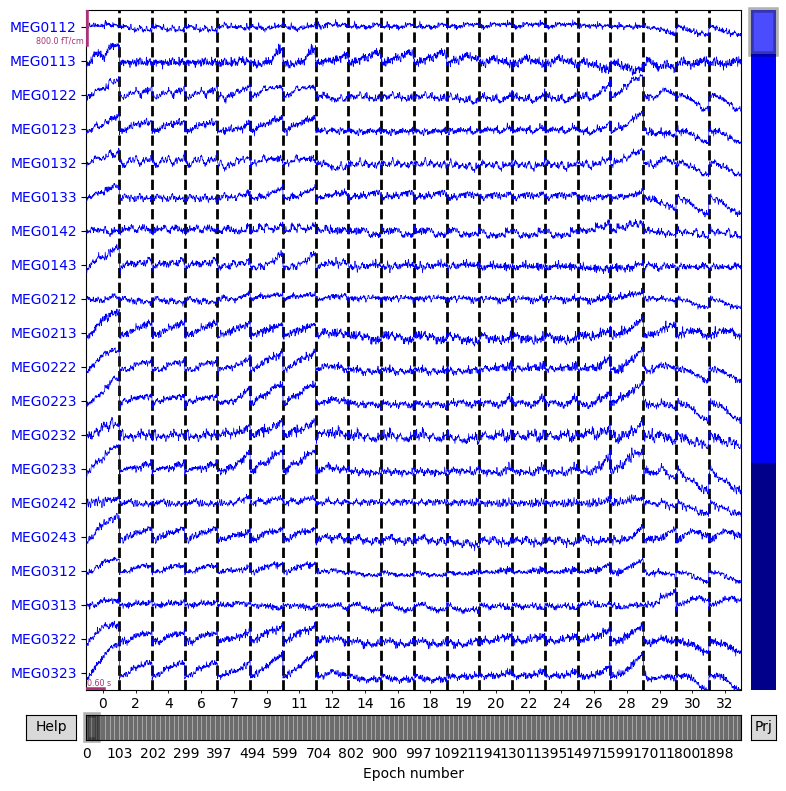

In [21]:
#Pick only MEG channels
epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False, stim=False, syst=False)

#show the epochs
epochs.plot()

In [22]:
# Characterizing epochs based on events
win_epochs = epochs['Win']
loss_epochs = epochs['Loss']
response_epochs = epochs['Response']
visual_epochs = epochs['Visual']
switch_epochs = epochs['Switch']

In [23]:
# %% EVOKED - AVERAGE - projections not applied

#Create evoked variables
win_evoked_responses = win_epochs.average()
loss_evoked_responses = loss_epochs.average()
response_evoked_responses = response_epochs.average()
visual_evoked_responses = visual_epochs.average()
switch_evoked_responses = switch_epochs.average()

In [24]:
#Comparing groups
mne.viz.plot_compare_evokeds(dict(win = win_evoked_responses, loss = loss_evoked_responses))


Multiple channel types selected, returning one figure per type.
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


[<Figure size 800x600 with 1 Axes>, <Figure size 800x600 with 1 Axes>]

## Classification - Hypothesis 2

In [25]:
# %% ARRAY OF INTEREST FOR CLASSIFICATIION
win_epochs1332=win_epochs.get_data(picks=['MEG1332'])
loss_epochs1332=loss_epochs.get_data(picks=['MEG1332'])
win_epochs1521=win_epochs.get_data(picks=['MEG1521'])
loss_epochs1521=loss_epochs.get_data(picks=['MEG1521'])

(163, 1201)


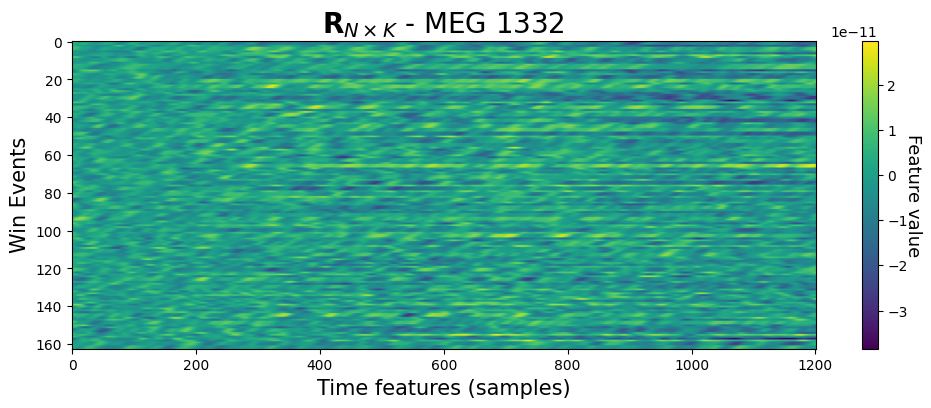

In [26]:
#The Numpy array is 3D. The 2nd dimension indexes the channel. We will slice it to get a 2D matrix.
win_epochs1332=win_epochs1332[:,0,:]
print(win_epochs1332.shape)
plt.figure(figsize=(12, 4))
plt.imshow(win_epochs1332, aspect='auto')
plt.xlabel('Time features (samples)', fontsize=15)
plt.ylabel('Win Events', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$ - MEG 1332', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

(56, 1201)


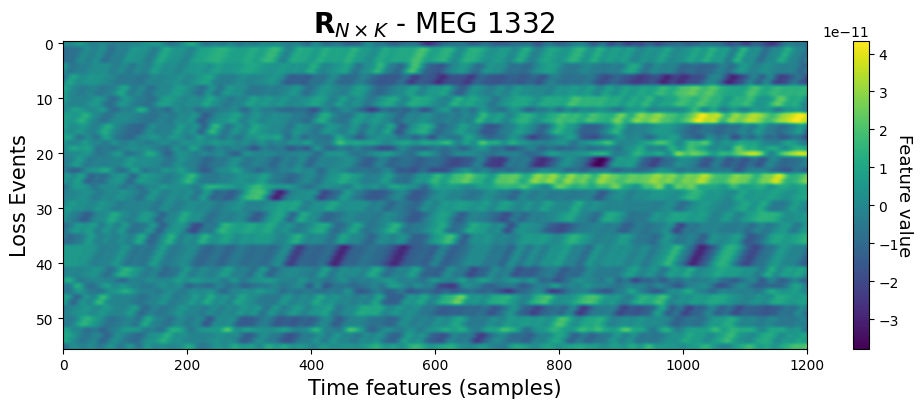

In [27]:
#The Numpy array is 3D. The 2nd dimension indexes the channel. We will slice it to get a 2D matrix.
loss_epochs1332=loss_epochs1332[:,0,:]
print(loss_epochs1332.shape)
plt.figure(figsize=(12, 4))
plt.imshow(loss_epochs1332, aspect='auto')
plt.xlabel('Time features (samples)', fontsize=15)
plt.ylabel('Loss Events', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$ - MEG 1332', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

In [28]:
import itertools
# Concatenate using numpy
all_epochs1332=np.concatenate((loss_epochs1332,win_epochs1332))
print(all_epochs1332.shape)

#Make list of classes to fit with our new dataset
condition=(list(itertools.repeat('loss',56))+list(itertools.repeat('win',163)))
print(condition)

(219, 1201)
['loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'loss', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 'win', 

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
X=all_epochs1332
y=condition  

# We will use the naive bayes classifier
classifier = GaussianNB()


X = StandardScaler().fit_transform(X)
#Divide the training set and test set into equal sizes.
X_train, X_test, y_train, y_test = \
   train_test_split(X, y, test_size=.5, random_state=42)
#Fit the training data
classifier.fit(X_train, y_train)
#Predict the test data, get score
score = classifier.score(X_test, y_test)
print('Percent accuracy on test data:', score)

Percent accuracy on test data: 0.7727272727272727


In [30]:
#Andreas' way of doing classification
# %% ARRAY OF INTEREST FOR CLASSIFICATIION

X = epochs.get_data()
y = epochs.events[:, 2]   #Choose the last column

times = epochs[0].times # get time points for later


#%% SIMPLE CLASSIFICATION
#Set functions for classification
import numpy as np

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        #print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.745, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()

In [31]:
#%% RUN FUNCTION
#More information about L2 penalty in logistic regression to prevent overfitting: https://www.geeksforgeeks.org/what-is-l2-penalty-in-logistic-regression/
#Classify based on two different trigger events
sensor_vis_win_vs_loss_deck1 = simple_classication(X,
                                  y, triggers=[210, 211],
                                  penalty='l2', C=1e-3)

In [32]:
mean_of_mean_scores = np.mean(sensor_vis_win_vs_loss_deck1)
print("Mean of mean_scores:", mean_of_mean_scores)

Mean of mean_scores: 0.6820149875104079


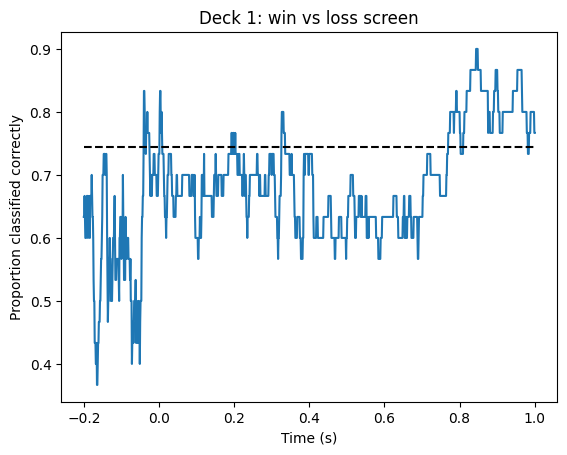

In [33]:
#%% PLOT
plot_classfication(times, sensor_vis_win_vs_loss_deck1,
                   title='Deck 1: win vs loss screen')

In [34]:
#%% COLLAPSE EVENTS (if you want to)
#You can assign new values to the triggers, so that you can combine several triggers into a group

def collapse_events(y, new_value, old_values=list()):
    new_y = y.copy()
    for old_value in old_values:
        new_y[new_y == old_value] = new_value
    return new_y

#First, collapse all win events and assign them value 1
y_vis_win_all = collapse_events(y, 1, [210, 220, 230, 240])   #the old values get assigned the new value '1'
#Second, collapse all loss events and assign them value 2
y_vis_win_and_loss_all = collapse_events(y_vis_win_all, 2, [211, 221, 231, 241])  #the old values get assigned the new value '2'

In [35]:
#%% CLASSIFCATION - COLLAPSED EVENTS

sensor_vis_win_loss_all = simple_classication(X,
                                  y_vis_win_and_loss_all, triggers=[1, 2],
                                  penalty='l2', C=1e-3)

In [36]:
mean_of_mean_scores_all = np.mean(sensor_vis_win_vs_loss_all)
print("Mean of mean_scores:", mean_of_mean_scores_all)

NameError: name 'sensor_vis_win_vs_loss_all' is not defined

In [ ]:
#%% PLOT COLLAPSED

plot_classfication(times, sensor_vis_win_loss_all,
                   title='Sensor space: win vs. loss for all decks')